# Consistency by Thibaut Louis

First a transfer function

$
\begin{align}
\tilde{a}_{\ell,m}^{T} &= a_{\ell,m}^{T}\\
\tilde{a}_{\ell,m}^{E} &= F_\ell a_{\ell,m}^{E}\\
\end{align}
$

which give

$
\begin{align}
\tilde{C}_\ell^{TT} &= C_\ell^{TT}\\
\tilde{C}_\ell^{TE} &= F_\ell C_\ell^{TE}\\
\tilde{C}_\ell^{EE} &= F_\ell^2C_\ell^{EE}
\end{align}
$

Then a leakage model

$
\begin{align}
\tilde{a}_{\ell,m}^{T} &= a_{\ell,m}^{T}\\
\tilde{a}_{\ell,m}^{E} &= a_{\ell,m}^{E} + \beta_\ell a_{\ell,m}^{T}\\
\end{align}
$

giving

$
\begin{align}
\tilde{C}_\ell^{TT} &= C_\ell^{TT}\\
\tilde{C}_\ell^{TE} &= C_\ell^{TE} + \beta_\ell C_\ell^{TT}\\
\tilde{C}_\ell^{EE} &= C_\ell^{EE} + 2\beta_\ell C_\ell^{TE} + \beta_\ell^2C_\ell^{TT}
\end{align}
$

We can also try to add some independant nuisance to EE mode with the following model

$
\begin{align}
\tilde{C}_\ell^{TT} &= C_\ell^{TT}\\
\tilde{C}_\ell^{TE} &= C_\ell^{TE}\\
\tilde{C}_\ell^{EE} &= \alpha_\ell C_\ell^{EE}
\end{align}
$

or a nuisance only on TE mode

$
\begin{align}
\tilde{C}_\ell^{TT} &= C_\ell^{TT}\\
\tilde{C}_\ell^{TE} &= \delta_\ell C_\ell^{TE}\\
\tilde{C}_\ell^{EE} &= C_\ell^{EE}
\end{align}
$


## Preamble

This notebook make use of [GetDist](https://getdist.readthedocs.io/en/latest/) python package to plot and to analyse MCMC samples.



In [1]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import yaml

Print versions used



In [2]:
import getdist
import matplotlib

getdist.chains.print_load_details = False

print("     Numpy :", np.__version__)
print("Matplotlib :", matplotlib.__version__)
print("   GetDist :", getdist.__version__)

     Numpy : 1.20.1
Matplotlib : 3.3.4
   GetDist : 1.1.3


## Definitions

Define CMB & nuisance parameter names.



In [3]:
cosmo_params = ["cosmomc_theta", "logA", "ns", "ombh2", "omch2", "H0", "tau"]
polareff_params = lambda n: [f"yp{i}" for i in range(n)]
leakage_params = lambda n: [f"bl{i}" for i in range(n)]
ee_crap_params = lambda n: [f"ap{i}" for i in range(n)]
te_crap_params = lambda n: [f"dt{i}" for i in range(n)]
sptpol_params = [
    "kappa",
    "czero_psEE_150",
    "ADust_TE",
    "ADust_EE",
    "alphaDust_TE",
    "alphaDust_EE",
    "mapTcal",
    "mapPcal",
    "beam1",
    "beam2",
]

Set a dictionnary holding the path to the MCMC chains and its name

In [4]:
config = yaml.safe_load(open("consistency.yml"))
mcmc_samples = {k: v.get("path") for k, v in config.get("samples").items()}

planck_lowl_samples = {k: v for k, v in mcmc_samples.items() if "lowl" in k}
sptpol_sub_samples = {k: v for k, v in mcmc_samples.items() if "SPTPol" in k}
te_crap_sub_samples = {k: v for k, v in mcmc_samples.items() if "TE crap" in k}

## MCMC chains

Let's plot the chains size

In [5]:
from cobaya_utilities.tools import print_chains_size

print_chains_size(mcmc_samples)

Have a look at how chains evolve with time and check convergence or not.



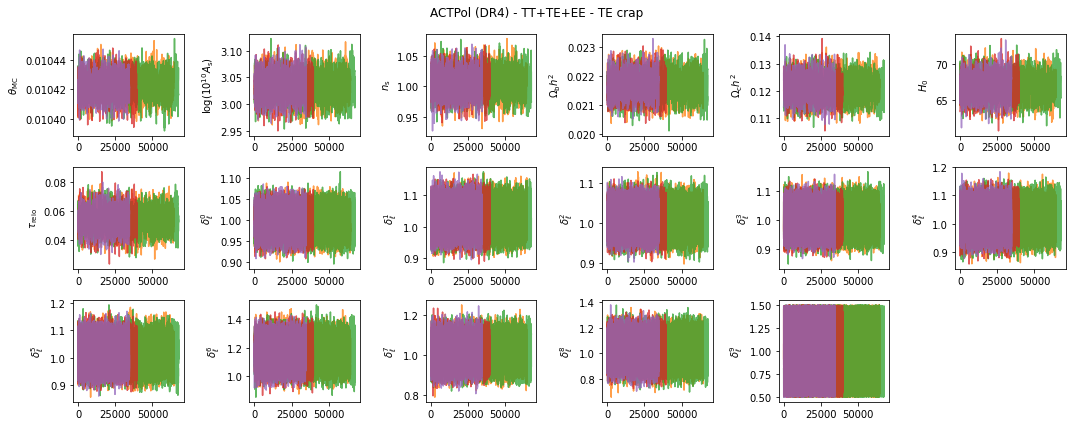

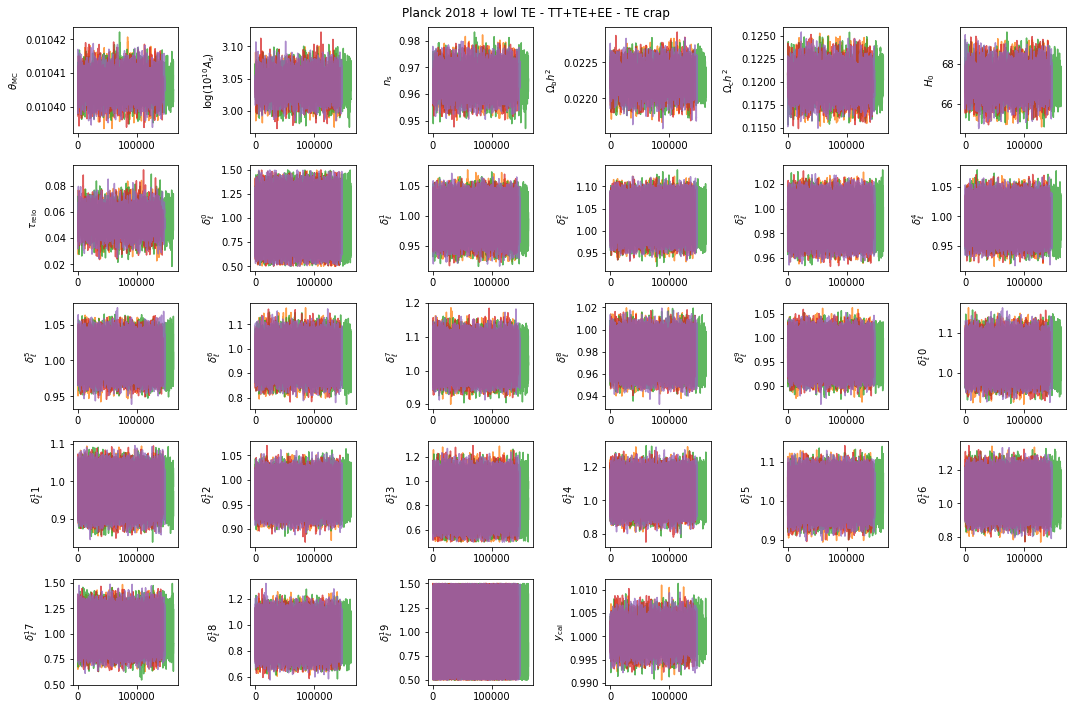

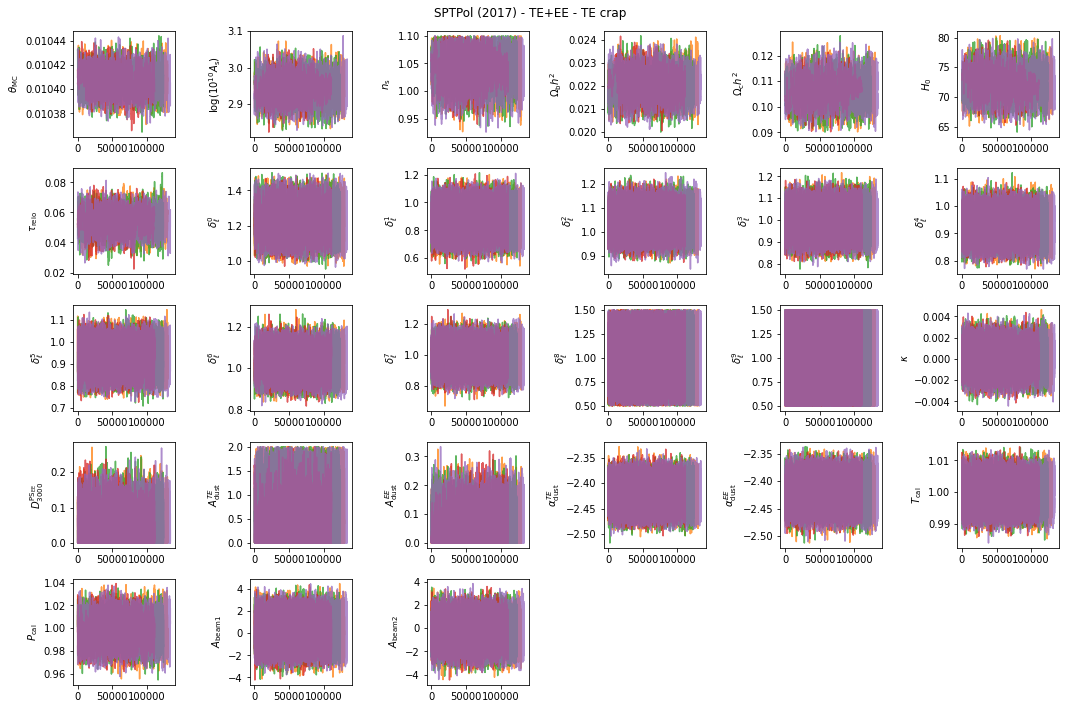

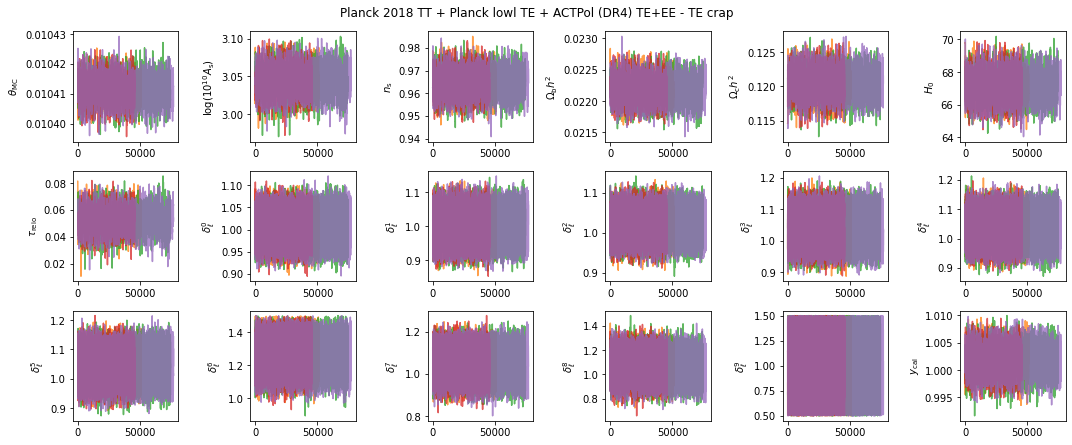

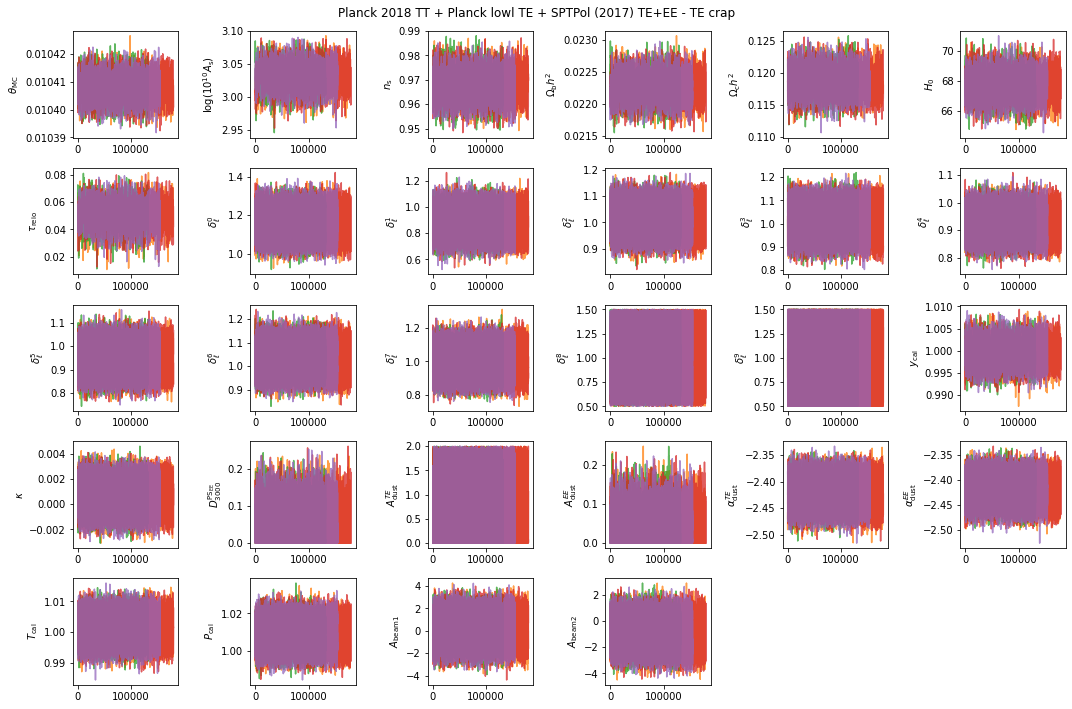

In [6]:
from cobaya_utilities.tools import plot_chains

for k, v in te_crap_sub_samples.items():
    n = 10 if "Pol" in k else 20
    nuisance_params = []
    if "polar eff." in k:
        nuisance_params = polareff_params(n)
    elif "leakage" in k:
        nuisance_params = leakage_params(n)
    elif "EE crap" in k:
        nuisance_params = ee_crap_params(n)
    elif "TE crap" in k:
        nuisance_params = te_crap_params(n)
    nuisance_params += ["A_planck"] if "Planck" in k else []
    nuisance_params += sptpol_params if "SPTPol" in k else []
    plot_chains(v, params=cosmo_params + nuisance_params, title=k, ncol=6, ignore_rows=0.4)

Let's plot also the Gelman $R-1$ parameter and acceptance rate progress

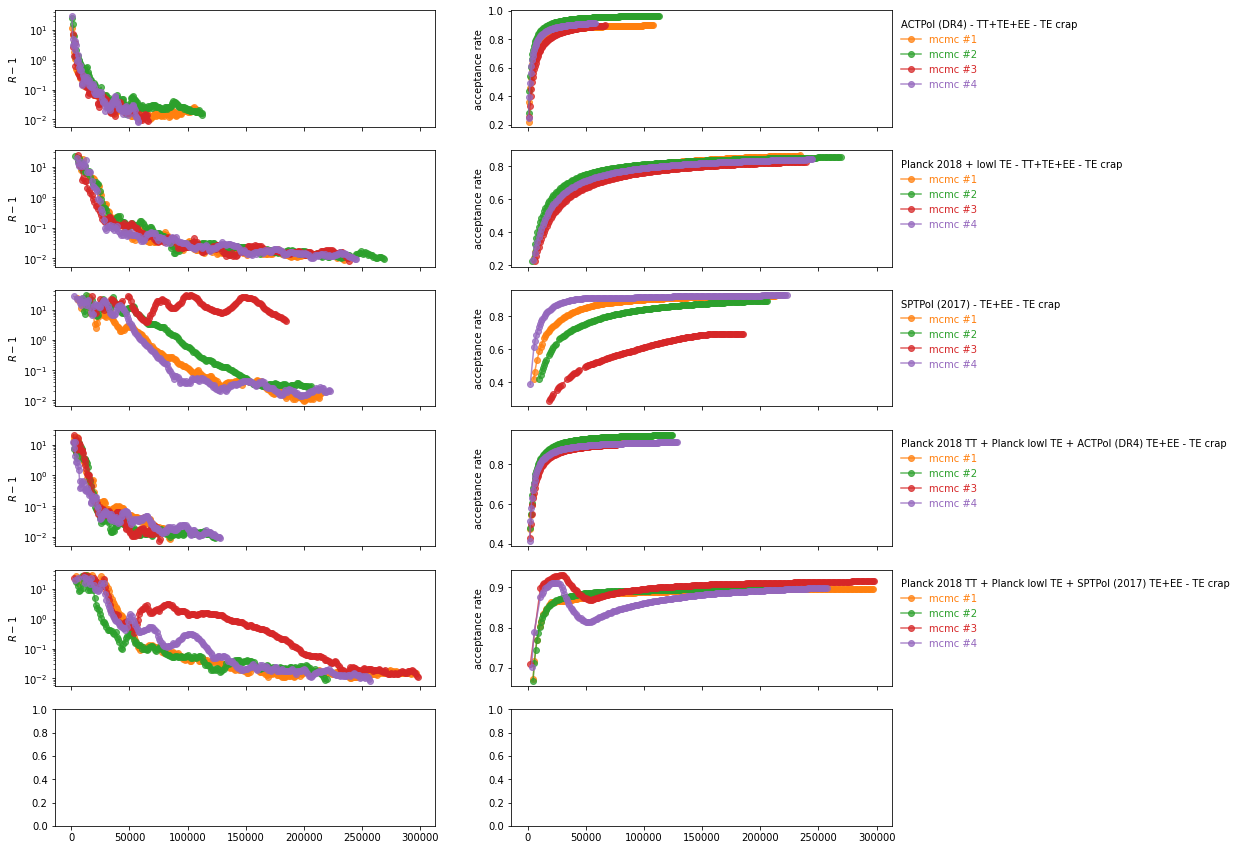

In [7]:
from cobaya_utilities.tools import plot_progress

plot_progress(te_crap_sub_samples)

## MCMC distributions



Define global plot settings

In [8]:
from getdist.plots import GetDistPlotSettings

plot_settings = GetDistPlotSettings()
plot_settings.num_plot_contours = 3
plot_settings.solid_colors = "tab20"
plot_settings.line_styles = "tab20"
plot_settings.linewidth = 2
plot_settings.legend_fontsize = 15
plot_settings.legend_colored_text = True

Load MCMC samples



In [9]:
from getdist import loadMCSamples

samples = [
    loadMCSamples(os.path.join(path, "mcmc"), settings={"ignore_rows": 0.4})
    for path in mcmc_samples.values()
]

In [10]:
colors = [v.get("color", "#00FF00") for v in config.get("samples").values()]

def get_sample_range(keywords):
    r = re.compile(keywords)
    return [i for i, k in enumerate(mcmc_samples.keys()) if r.match(k)]


def triangle_plot(sample_range, params, ccolors=None, show_tau_prior=True):
    from getdist import plots

    g = plots.get_subplot_plotter(settings=plot_settings)
    legend_labels = [k for i, k in enumerate(mcmc_samples.keys()) if i in sample_range]
    ssamples = [sample for i, sample in enumerate(samples) if i in sample_range]
    if ccolors is None:
        ccolors = [color for i, color in enumerate(colors) if i in sample_range]
    g.triangle_plot(
        ssamples,
        params,
        filled=False,
        legend_labels=legend_labels,
        colors=ccolors,
        diag1d_kwargs={"colors": ccolors},
    )
    if show_tau_prior:
        # Show prior on tau
        from scipy.stats import norm

        ax = g.subplots[-1, -1]
        xmin, xmax, ymin, ymax = ax.axis()
        x = np.linspace(xmin, xmax, 100)
        y = norm.pdf(x, 0.054, 0.0073)

        ax.plot(x, y / np.max(y), color="gray", ls="--", label=r"$\tau$ prior")
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1));

### ACTPol

Plot posteriors distributions of CMB parameters

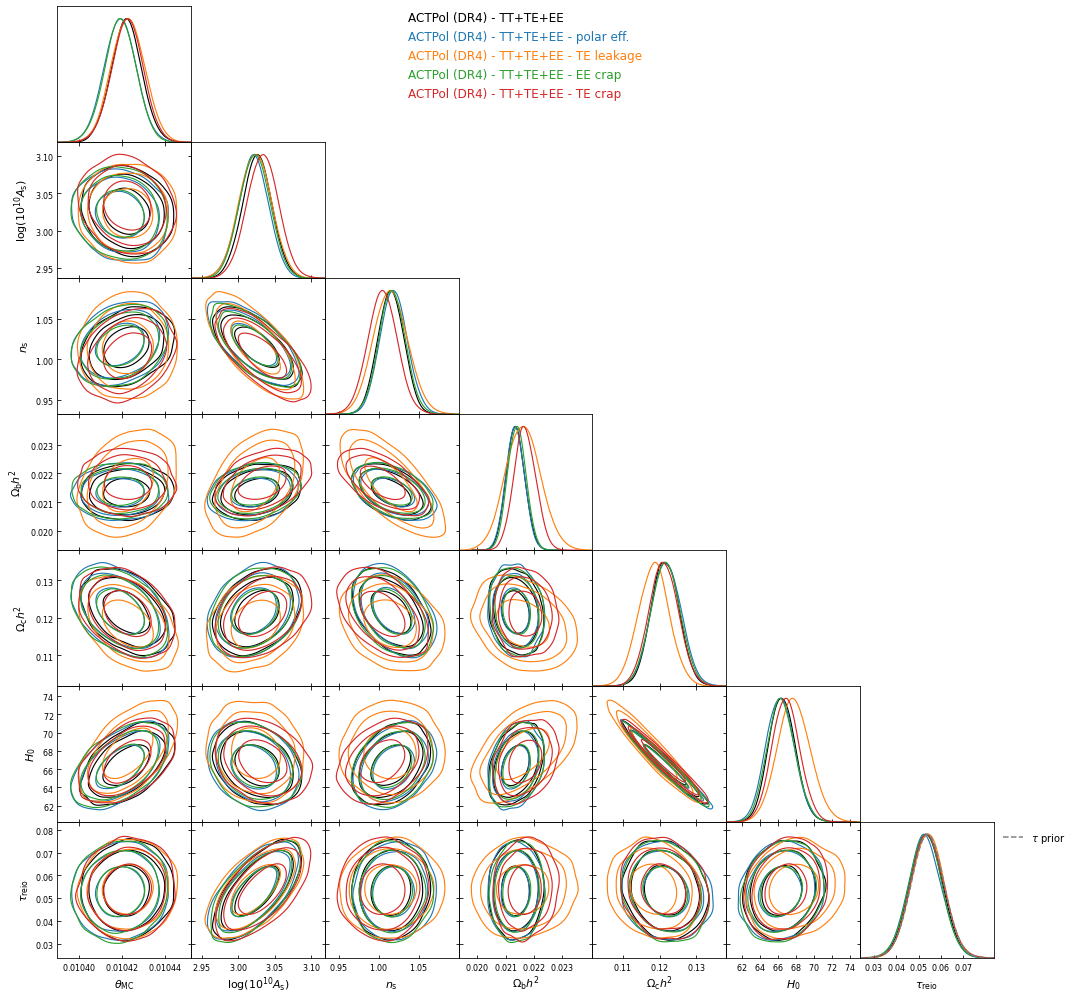

In [11]:
triangle_plot(
    sample_range=get_sample_range("ACTPol.*TT\+"),
    params=cosmo_params,
    ccolors=["black"] + [f"C{i}" for i in range(5)],
)

### SPTPol

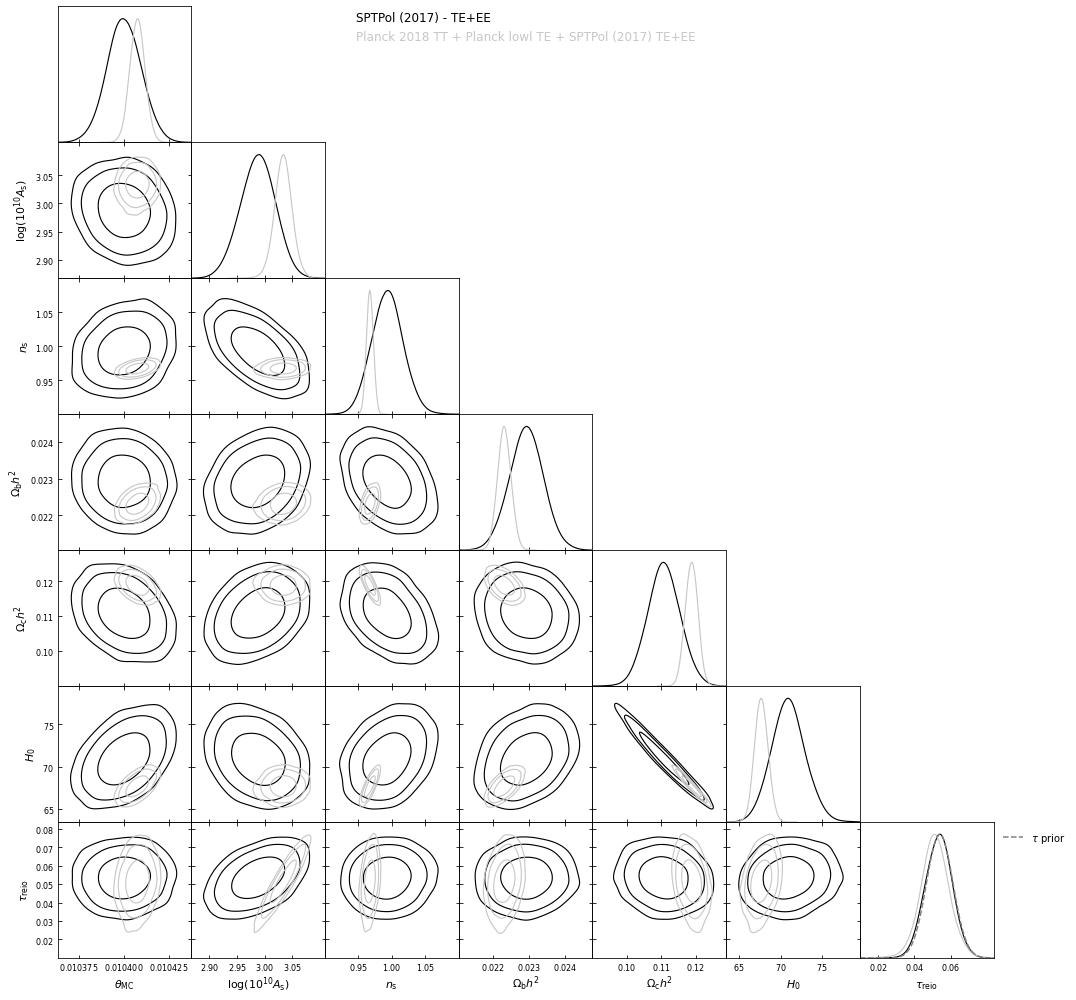

In [12]:
triangle_plot(
    sample_range=get_sample_range("SPTPol.*TE\+EE$") + get_sample_range("Planck.*SPTPol.*TE\+EE$"),
    params=cosmo_params,
)

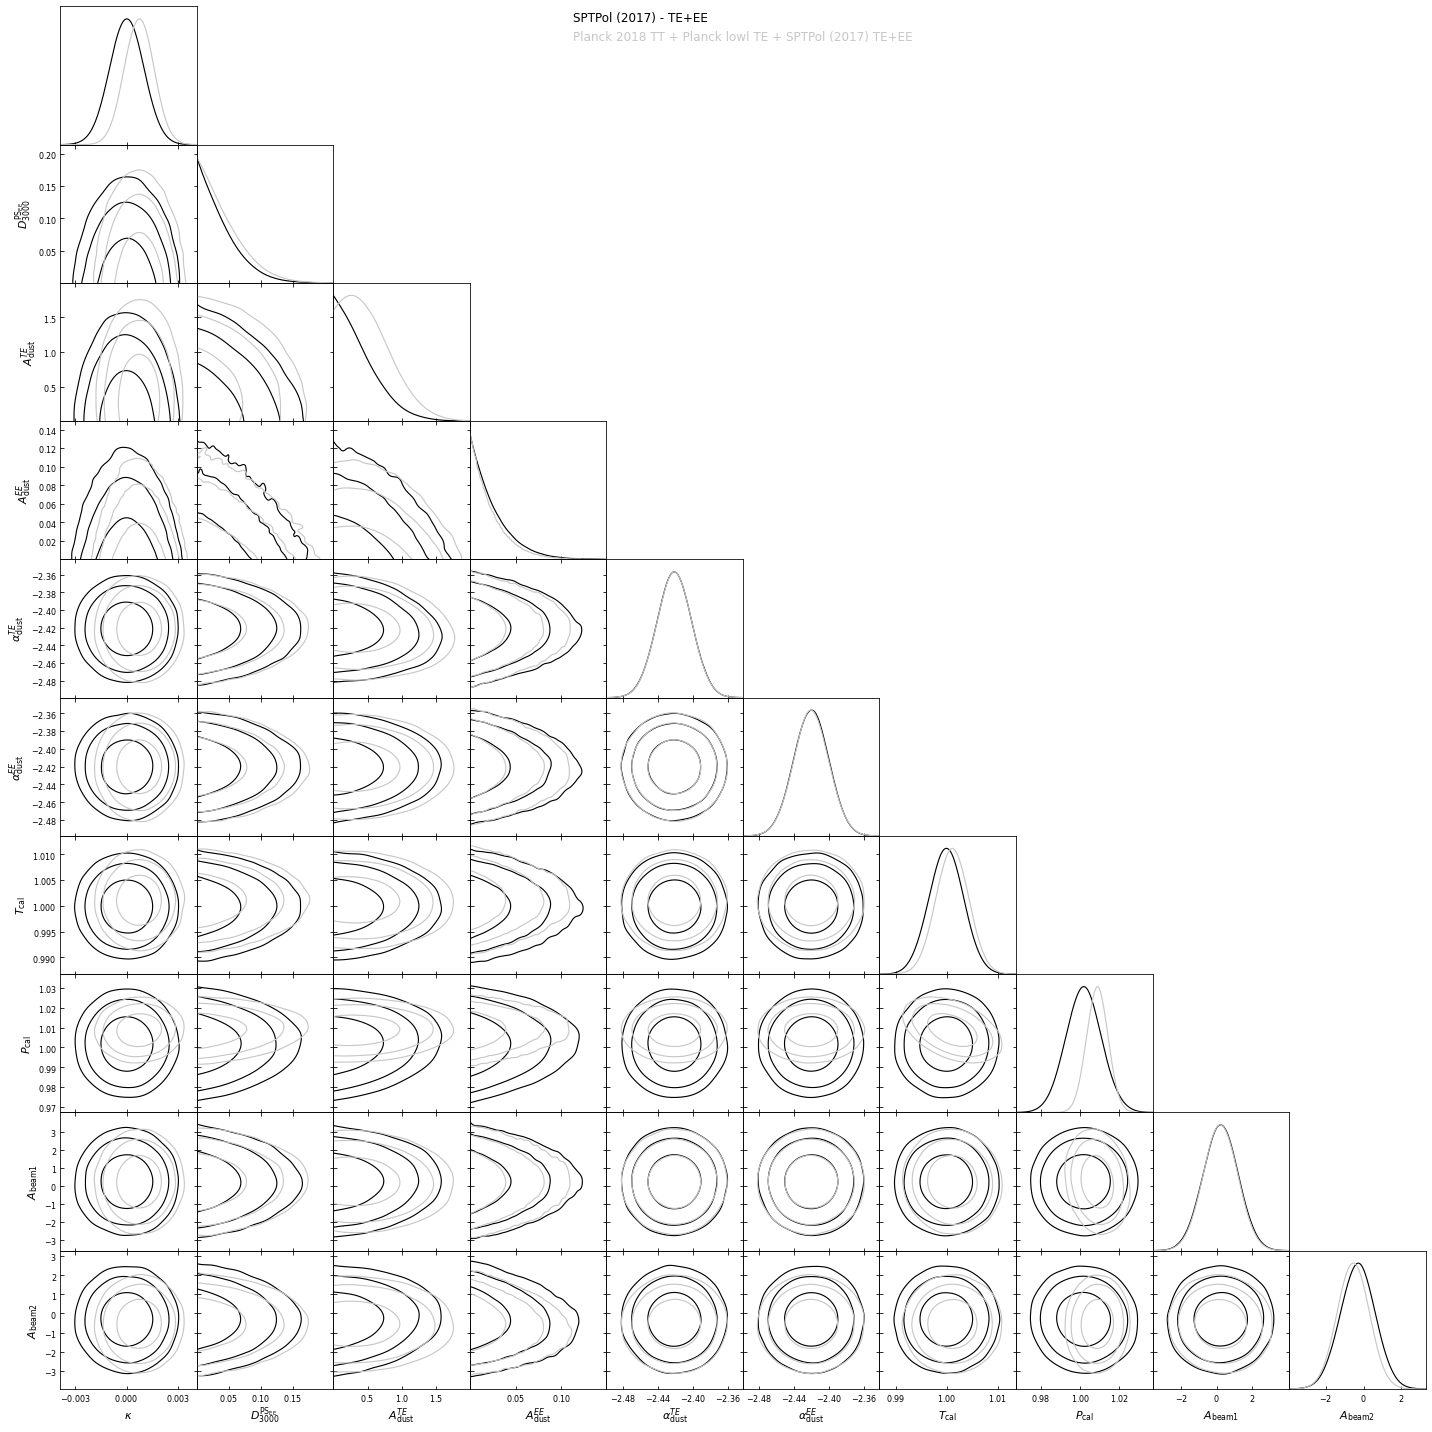

In [13]:
triangle_plot(
    sample_range=get_sample_range("SPTPol.*TE\+EE$") + get_sample_range("Planck.*SPTPol.*TE\+EE$"),
    params=sptpol_params,
    show_tau_prior=False,
)

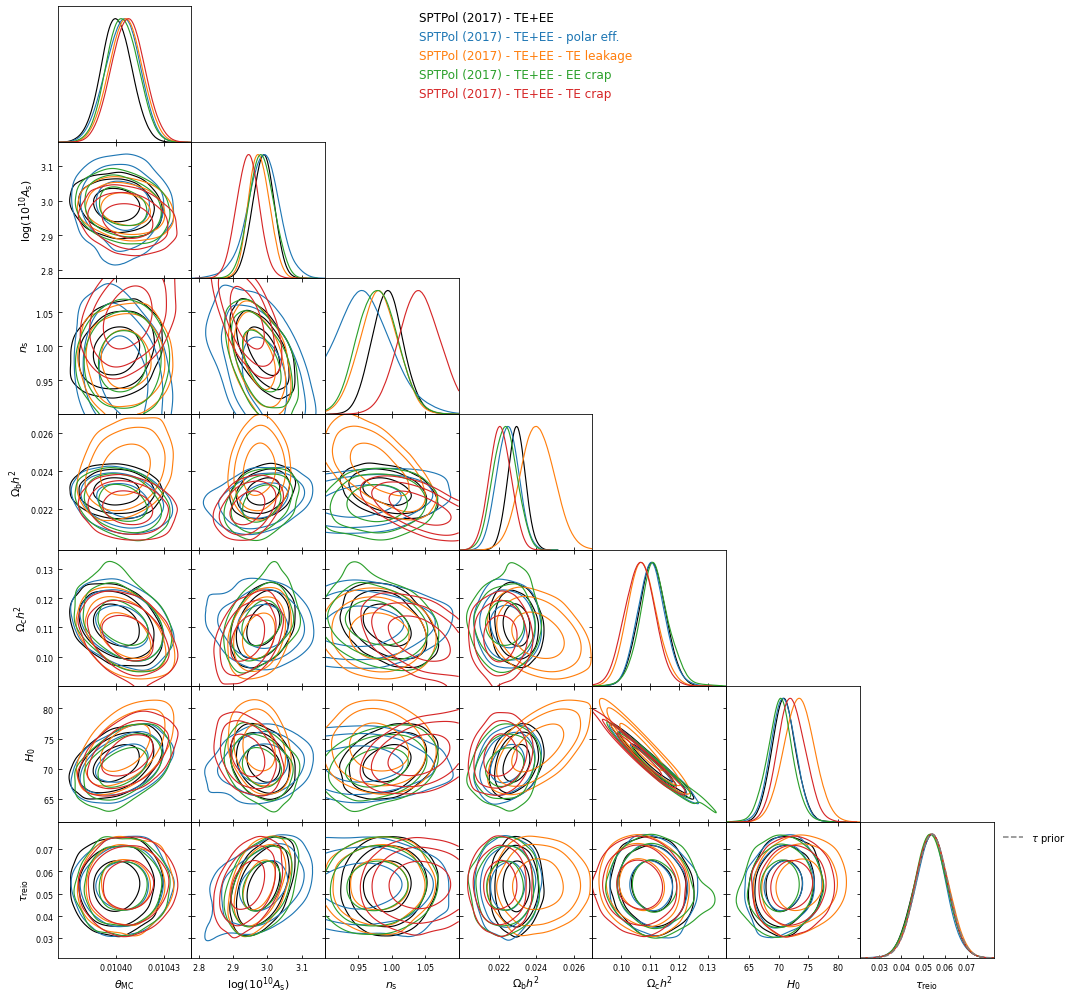

In [14]:
triangle_plot(
    sample_range=get_sample_range("SPTPol.*TE\+"),
    params=cosmo_params,
    ccolors=["black"] + [f"C{i}" for i in range(5)],
)

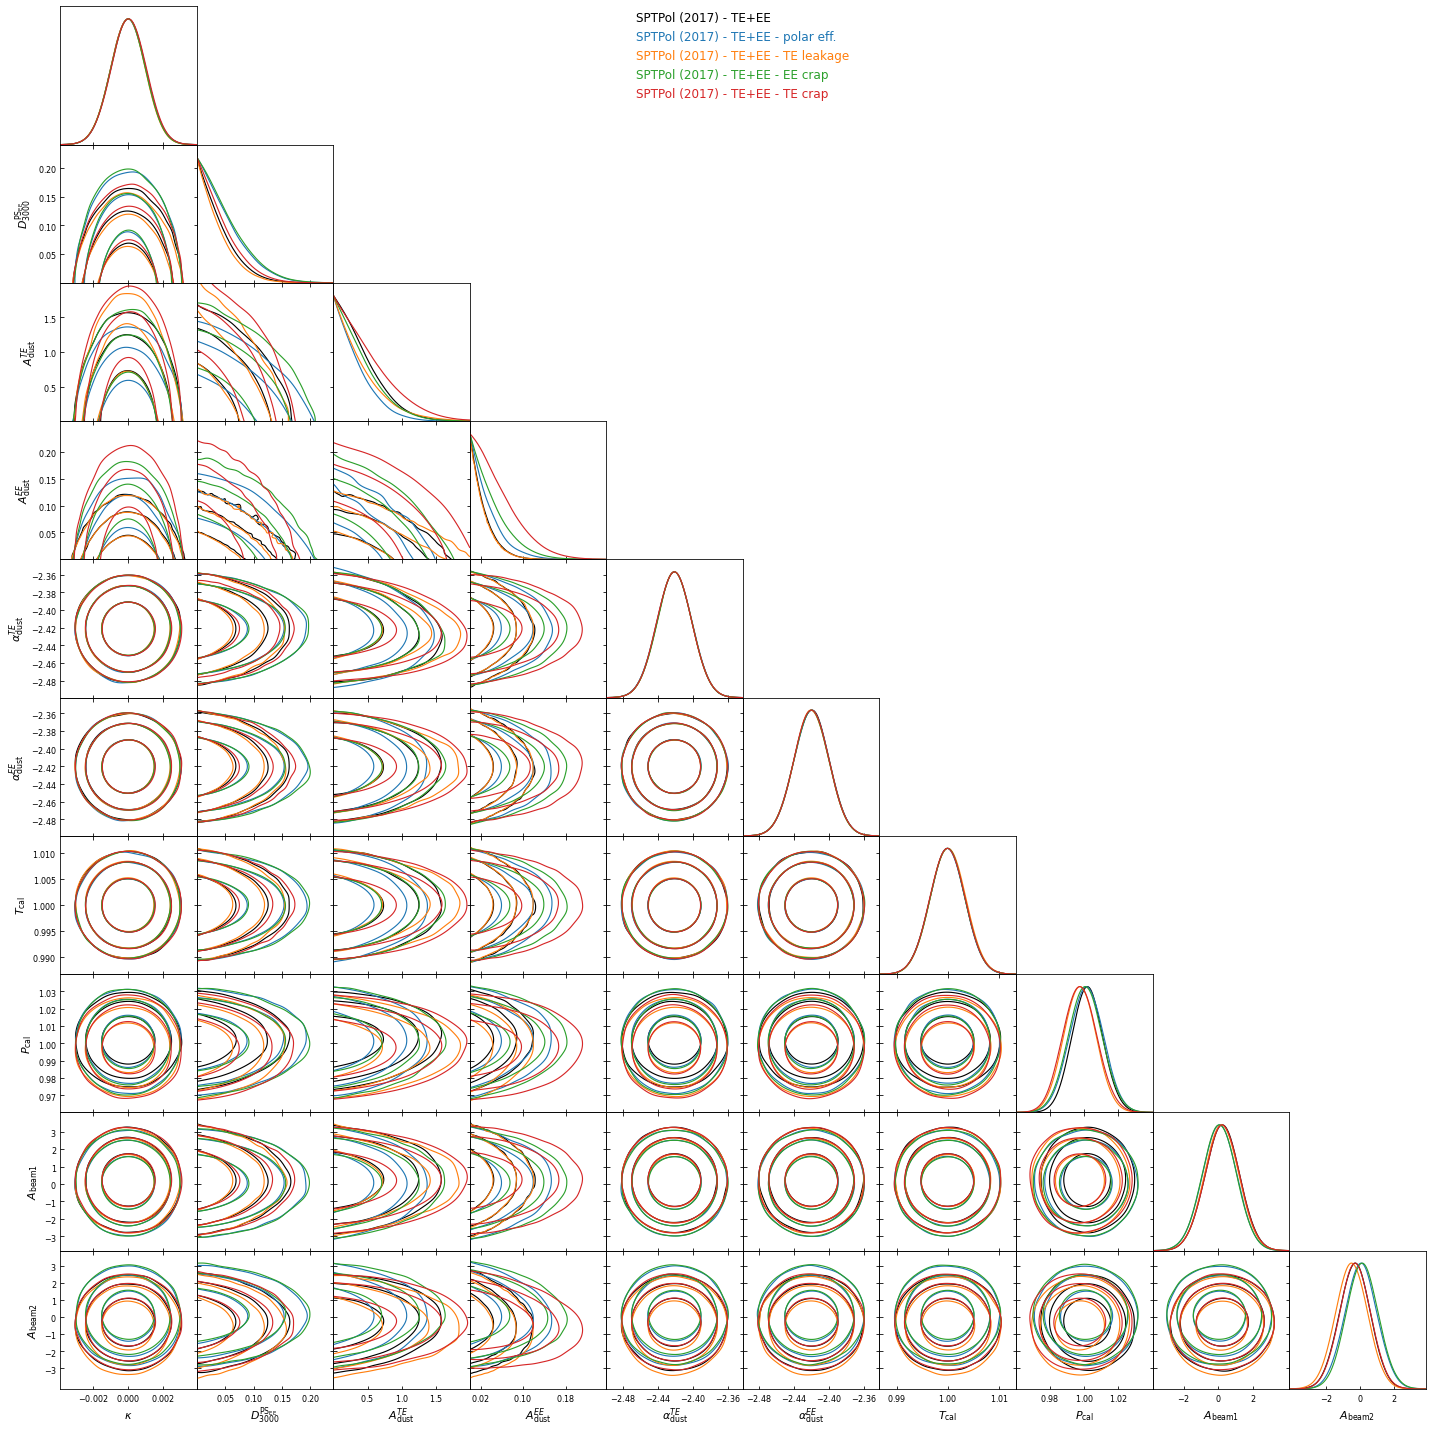

In [15]:
triangle_plot(
    sample_range=get_sample_range("SPTPol.*TE\+"),
    params=sptpol_params,
    ccolors=["black"] + [f"C{i}" for i in range(5)],
    show_tau_prior=False,
)

### Planck

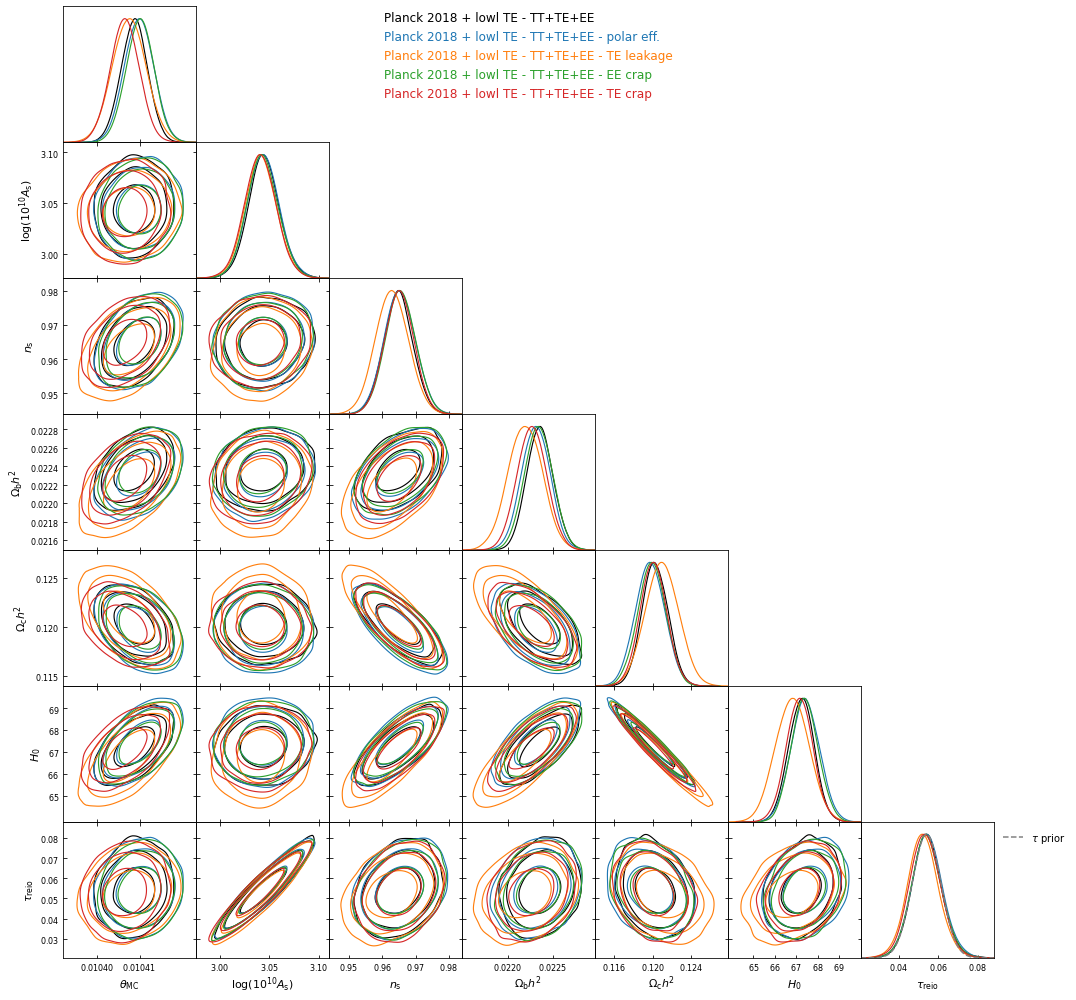

In [16]:
triangle_plot(
    sample_range=get_sample_range("Planck.*TT\+"),
    params=cosmo_params,
    ccolors=["black"] + [f"C{i}" for i in range(5)],
)

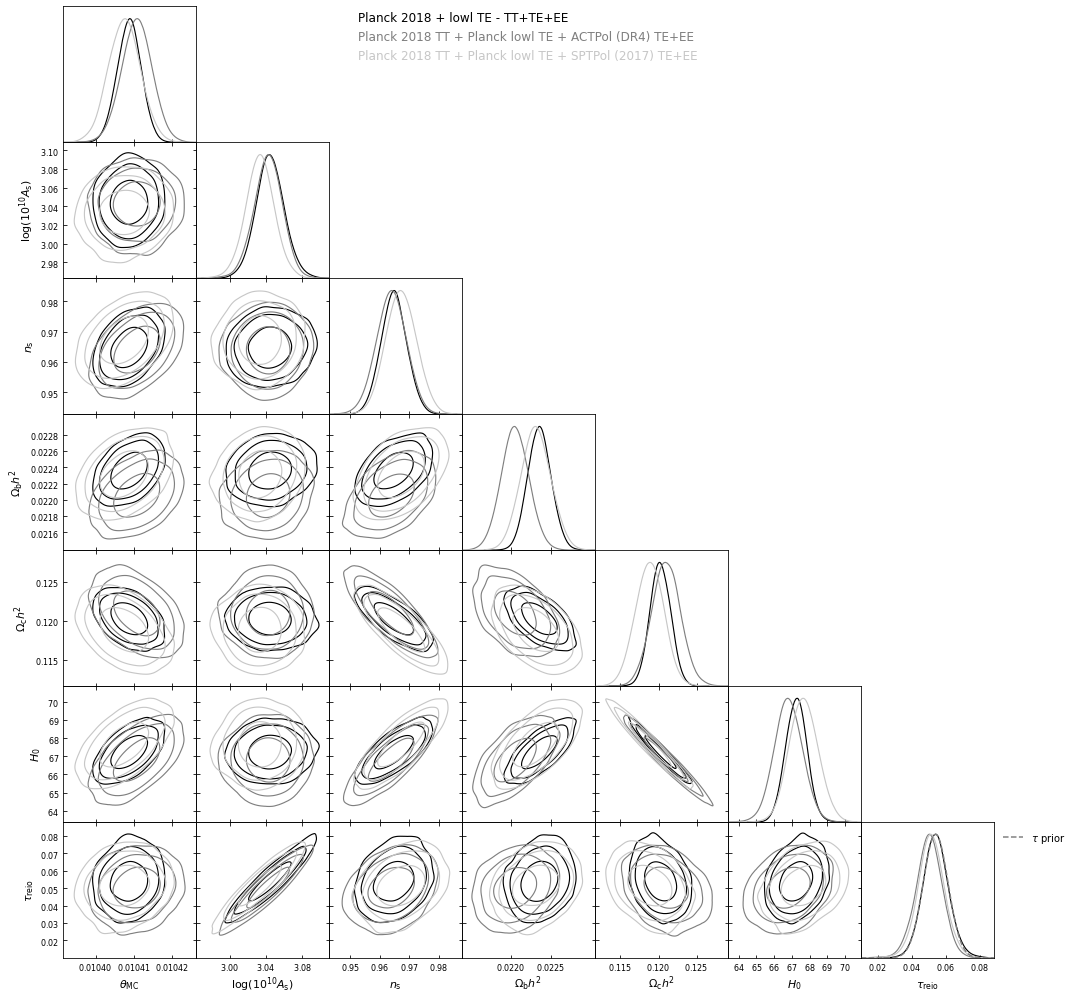

In [17]:
triangle_plot(
    sample_range=get_sample_range("Planck.*TT\+TE\+EE$")
    + get_sample_range("Planck.*lowl.*(ACTPol|SPTPol).*TE\+EE$"),
    params=cosmo_params,
)

## Correlation plots

In [18]:
def rectangle_plot(sample_range, params1, params2):
    from getdist import plots

    g = plots.get_subplot_plotter(settings=plot_settings)
    legend_labels = [k for i, k in enumerate(mcmc_samples.keys()) if i in sample_range]
    roots = [sample for i, sample in enumerate(samples) if i in sample_range]
    ccolors = [color for i, color in enumerate(colors) if i in sample_range]
    g.rectangle_plot(
        params1,
        params2,
        roots=roots,
        filled=True,
        legend_labels=legend_labels,
        colors=ccolors,
    );

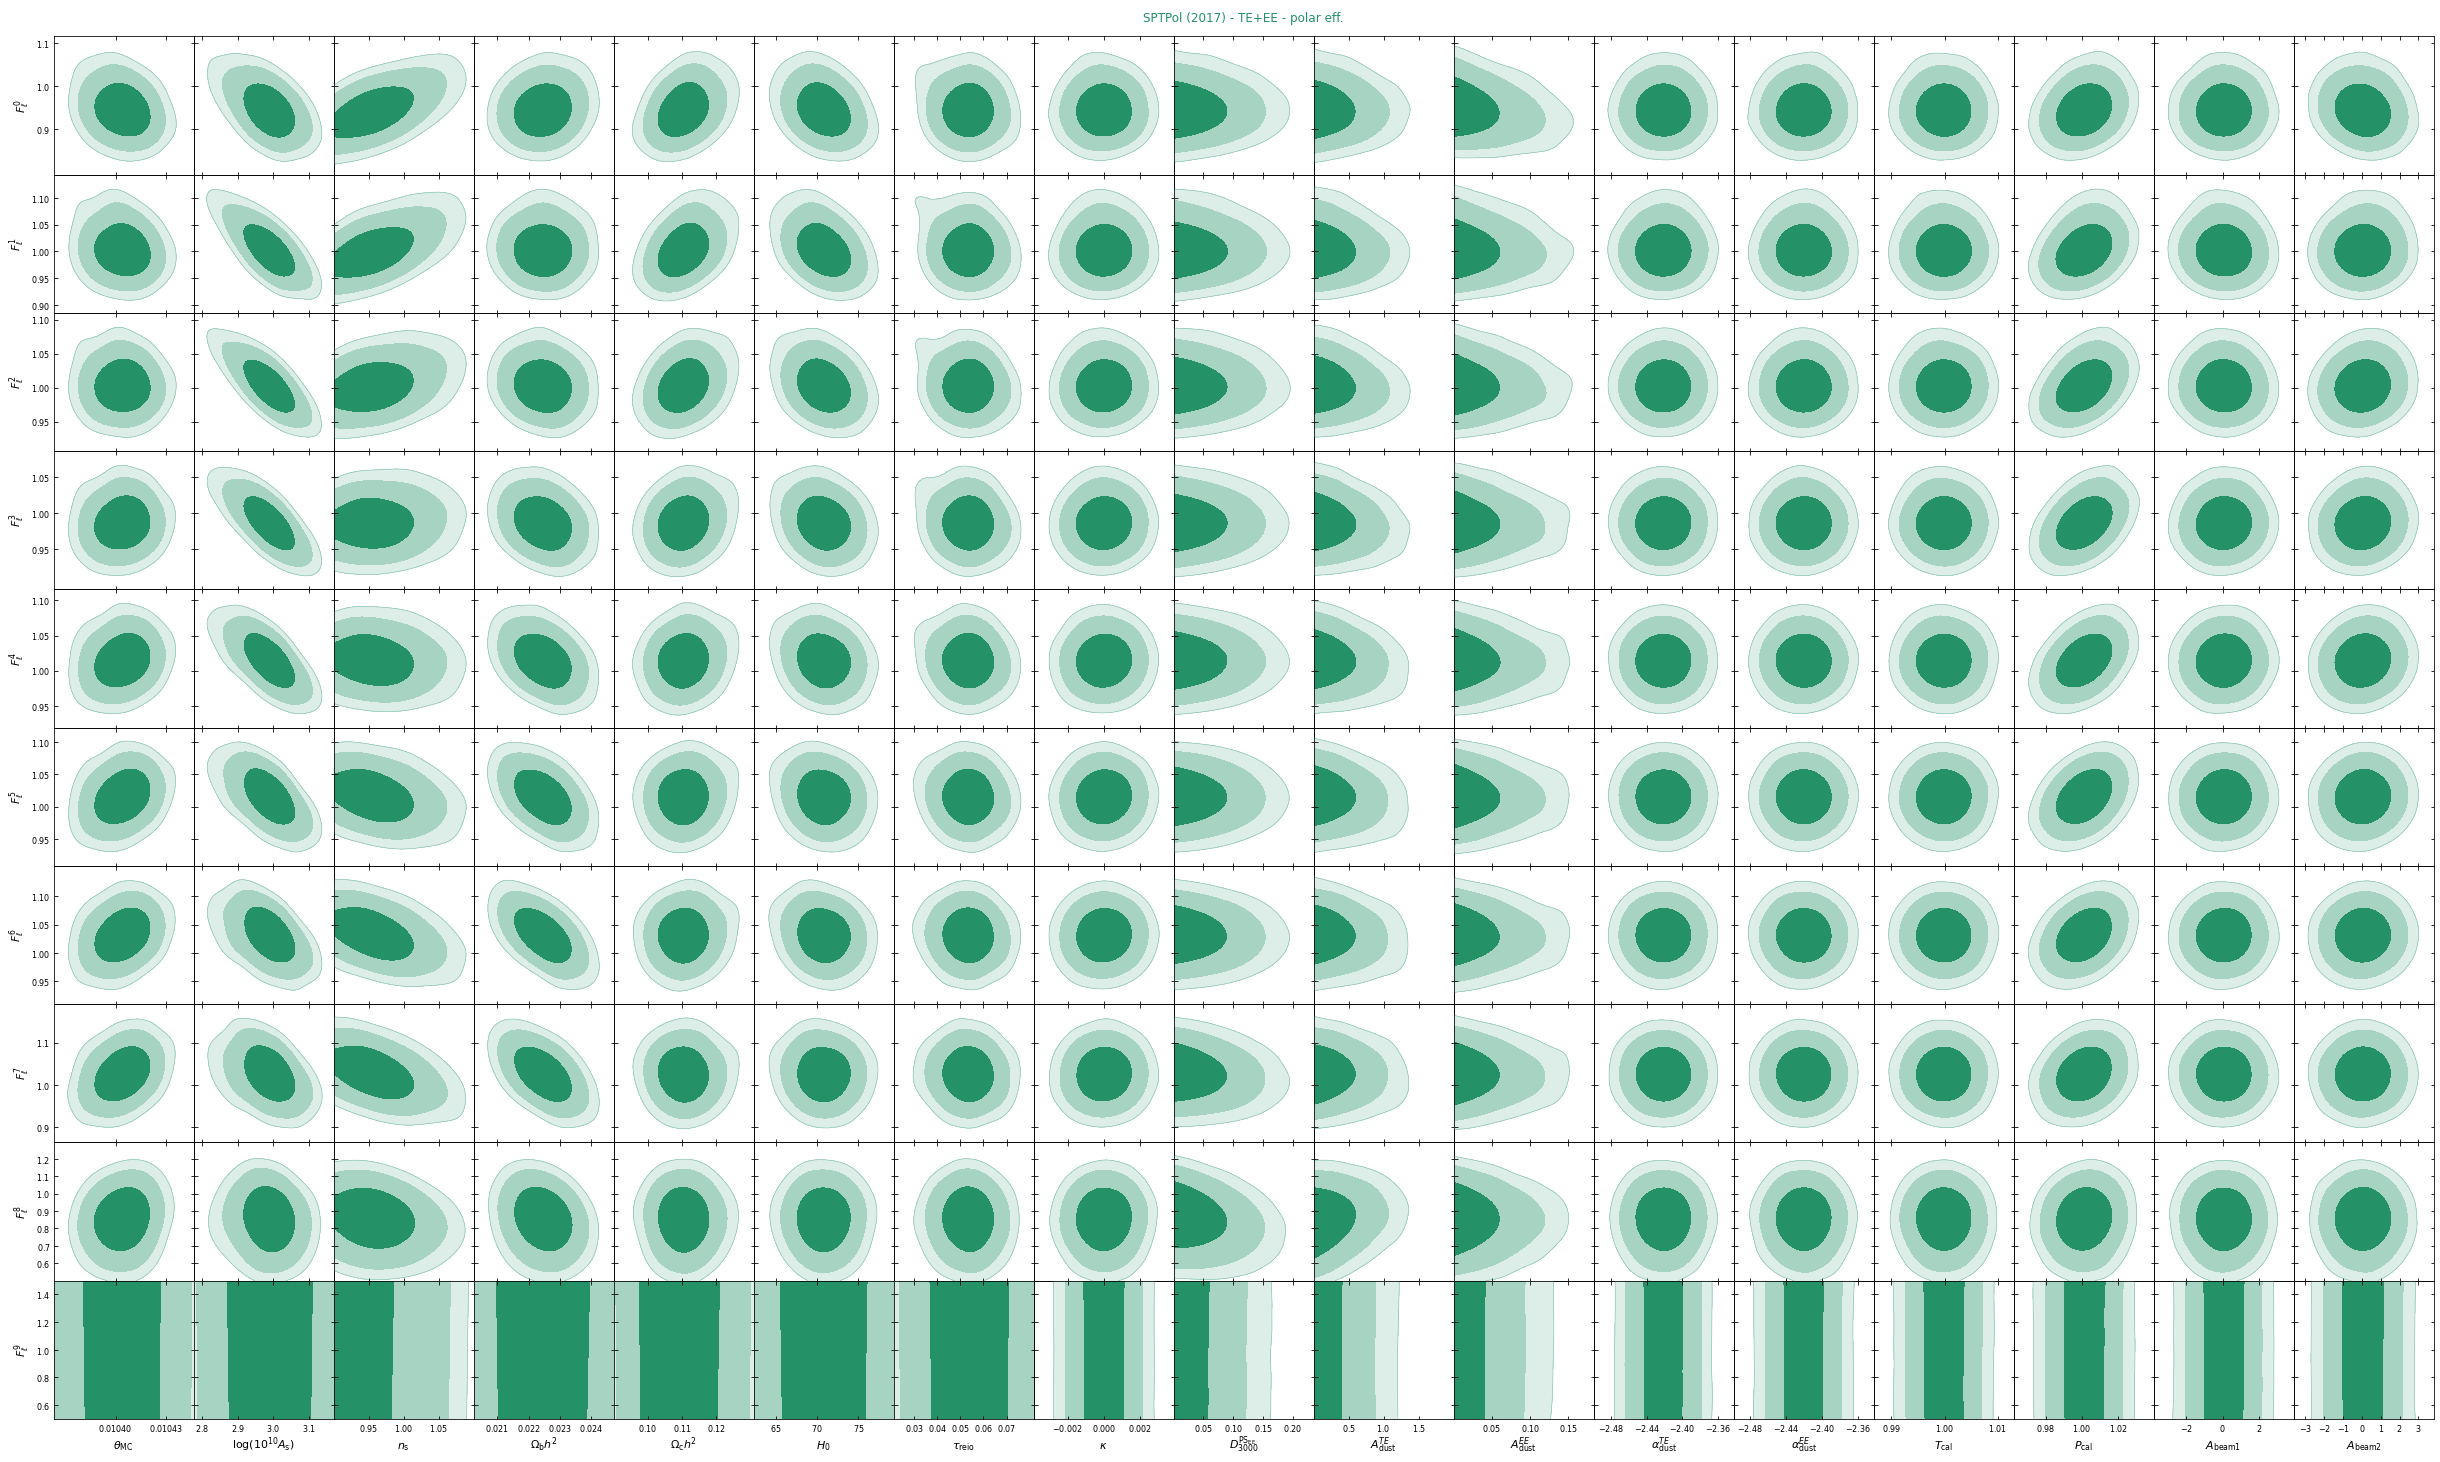

In [19]:
rectangle_plot(get_sample_range("SPTPol.*polar"), params1=cosmo_params+sptpol_params, params2=polareff_params(10))

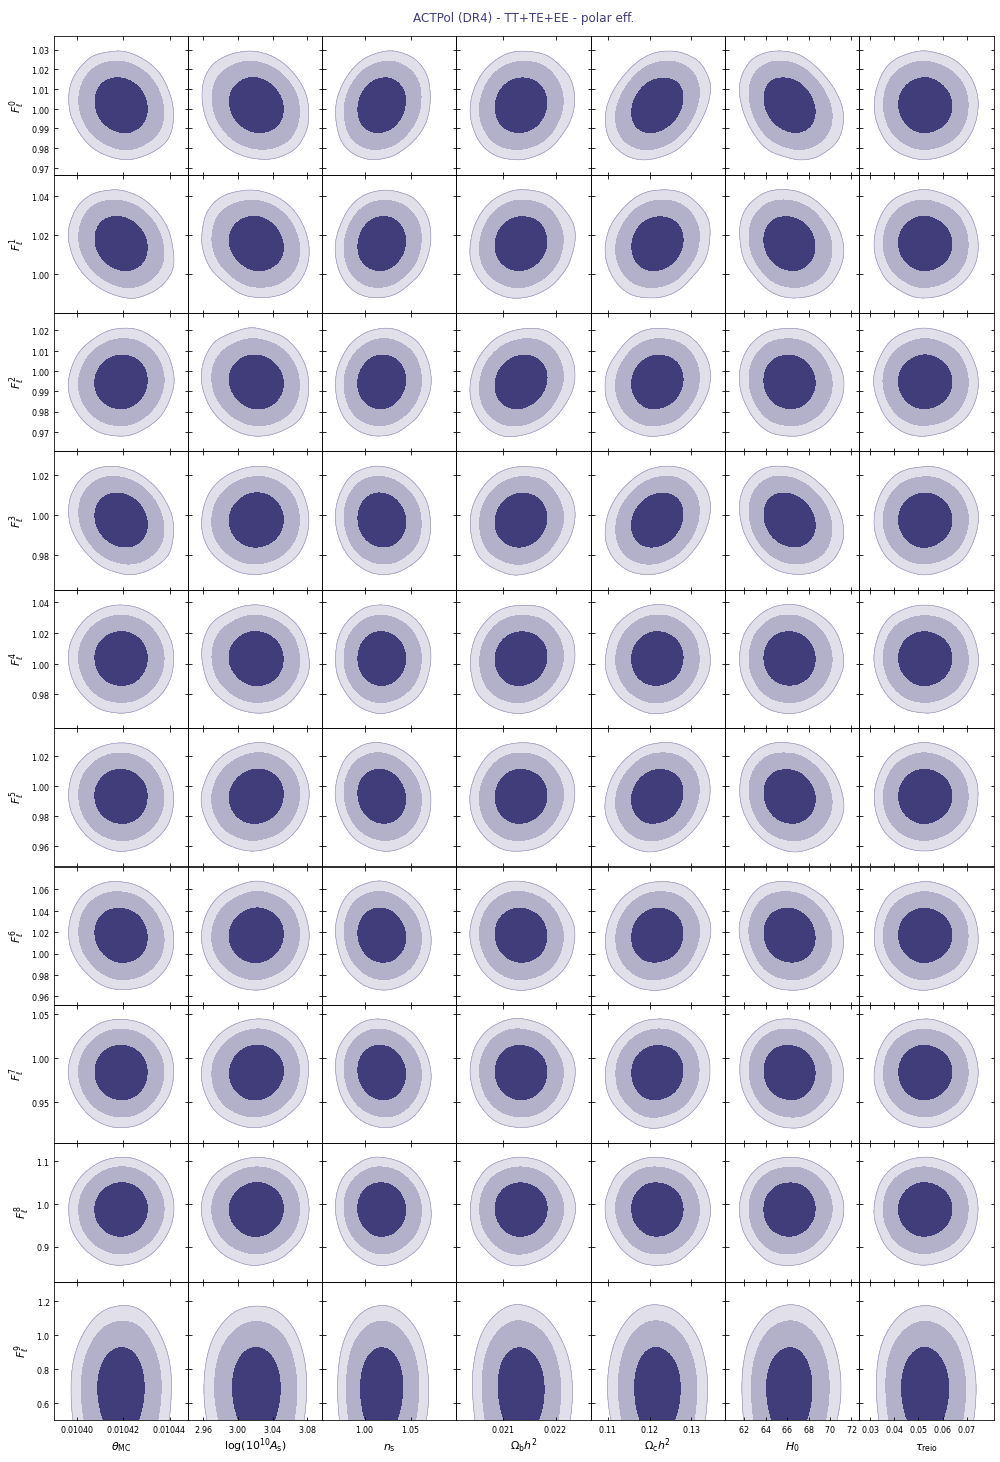

In [20]:
rectangle_plot(get_sample_range("ACTPol.*polar"), params1=cosmo_params, params2=polareff_params(10))

In [21]:
def plot_correlation(sample_range, sharey=True):
    ssamples = [sample for i, sample in enumerate(samples) if i in sample_range]
    labels = [k for i, k in enumerate(mcmc_samples.keys()) if i in sample_range]
    fig, axes = plt.subplots(1, len(labels), figsize=(8 * len(labels), 8), sharey=sharey)
    if len(sample_range) == 1:
        axes = np.array([axes])
    for i, ax in enumerate(axes):
        covmat = ssamples[i].getCovMat()
        params = [f"${ssamples[i].parLabel(param)}$" for param in covmat.paramNames]
        im = ax.imshow(covmat.correlation(), cmap="RdBu", vmin=-1, vmax=+1)
        ax.set_xticks(np.arange(len(params)))
        ax.set_xticklabels(params, rotation="vertical")
        ax.set_yticks(np.arange(len(params)))
        ax.set_yticklabels(params)
        ax.set_title(labels[i])
        asp = np.diff(axes[0].get_xlim())[0] / np.diff(axes[0].get_ylim())[0]
        ax.set_aspect(1 / np.abs(asp))
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.25, 0.025, 0.5])
    fig.colorbar(im, cax=cbar_ax);

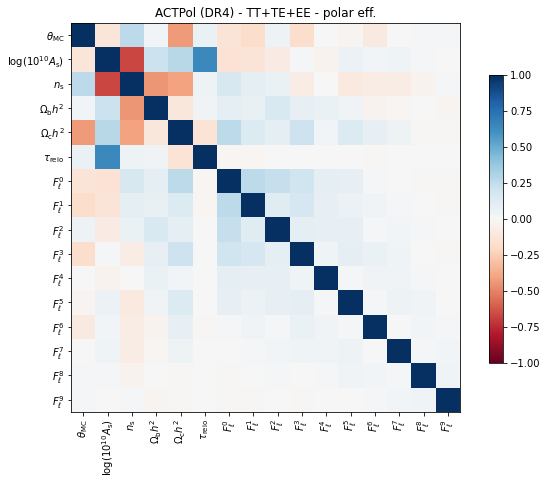

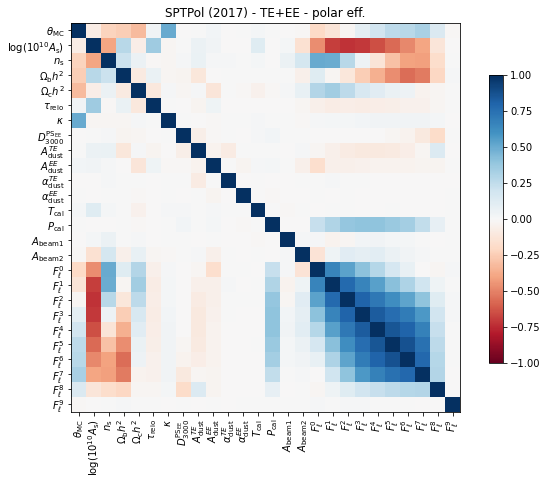

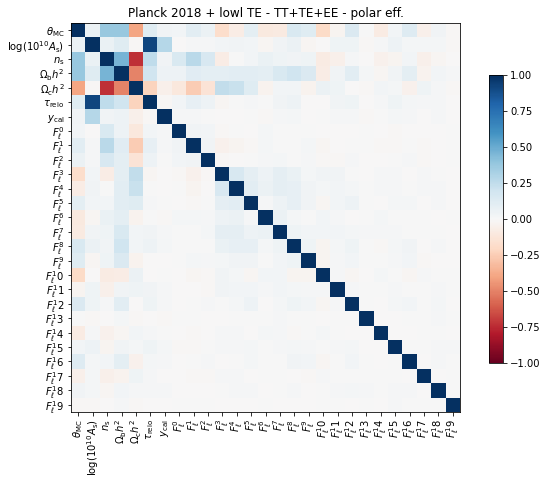

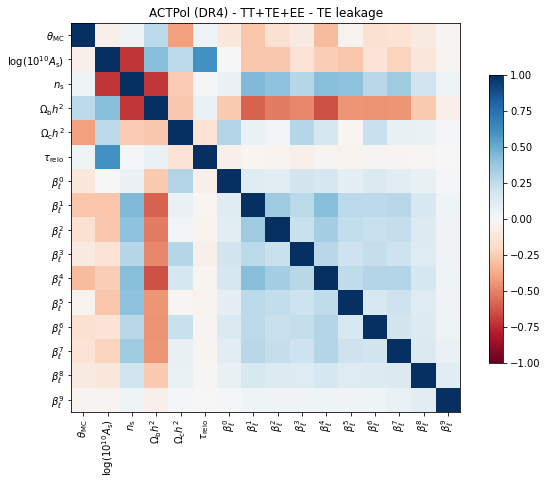

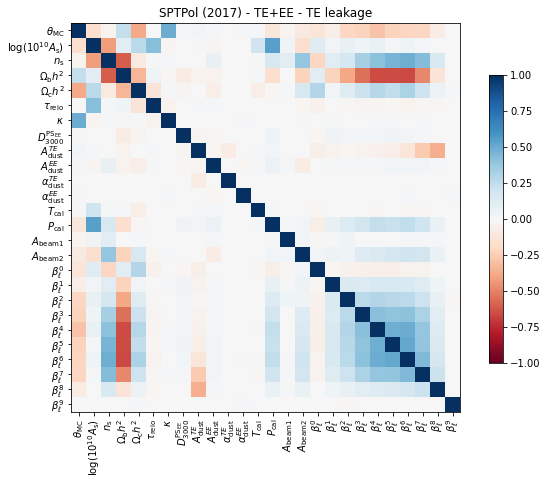

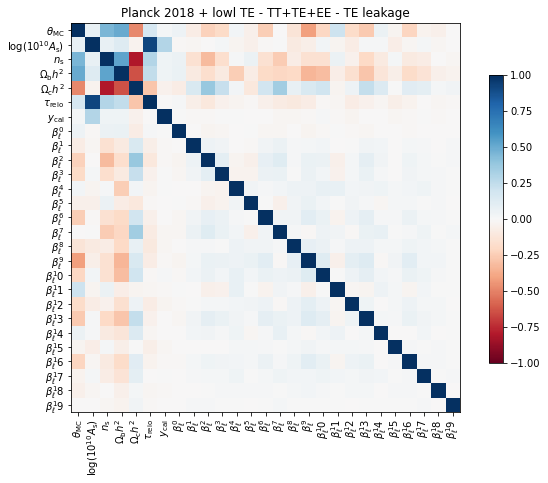

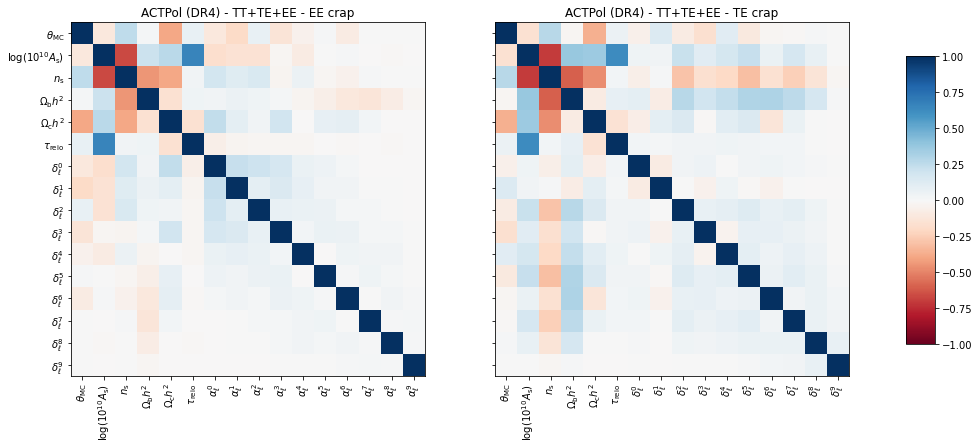

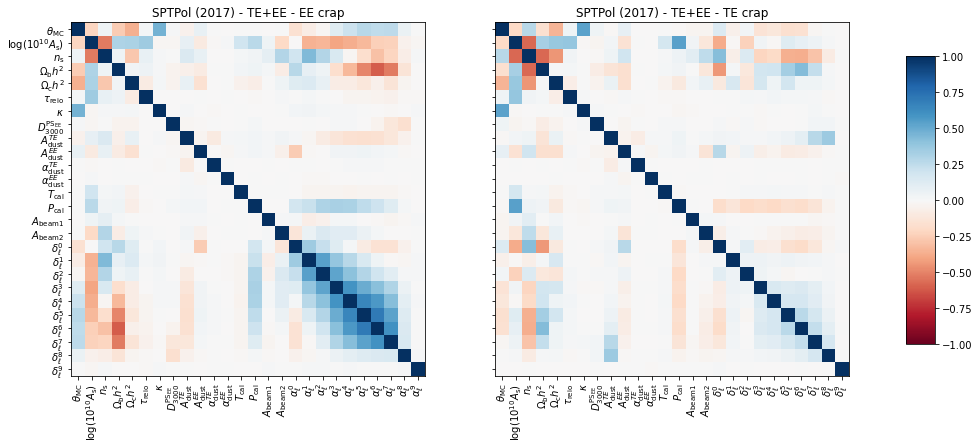

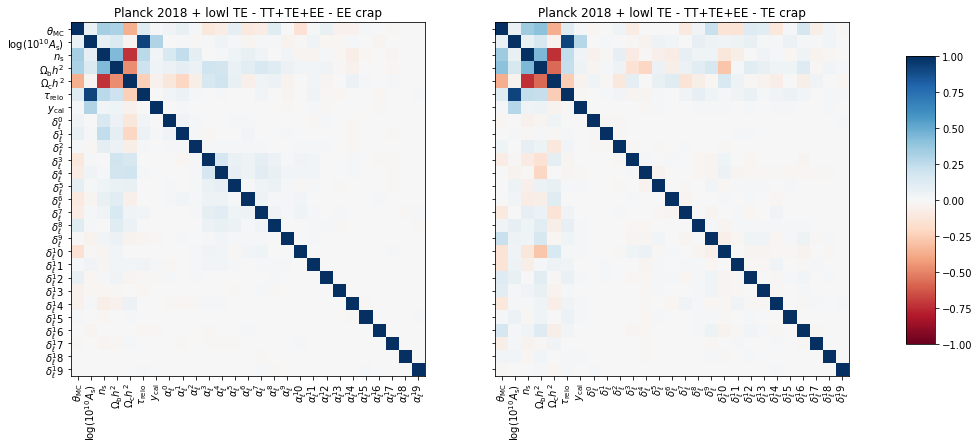

In [22]:
from itertools import product

for nuisance, exp in product(["polar", "leakage", "crap"], ["ACTPol", "SPTPol", "Planck"]):
    plot_correlation(get_sample_range(f"{exp}.*-.*TE\+EE.*{nuisance}"))

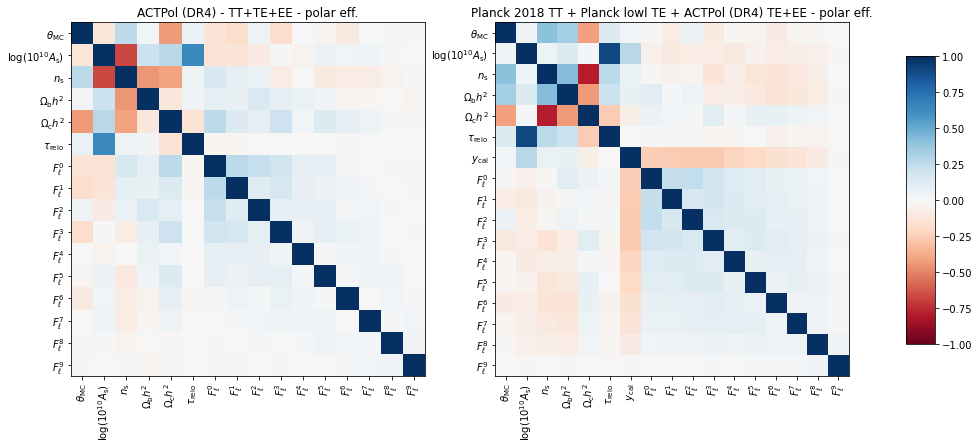

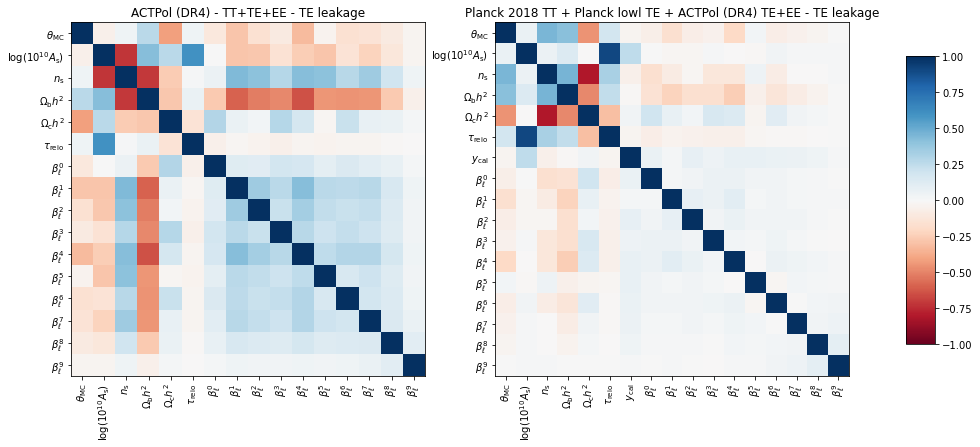

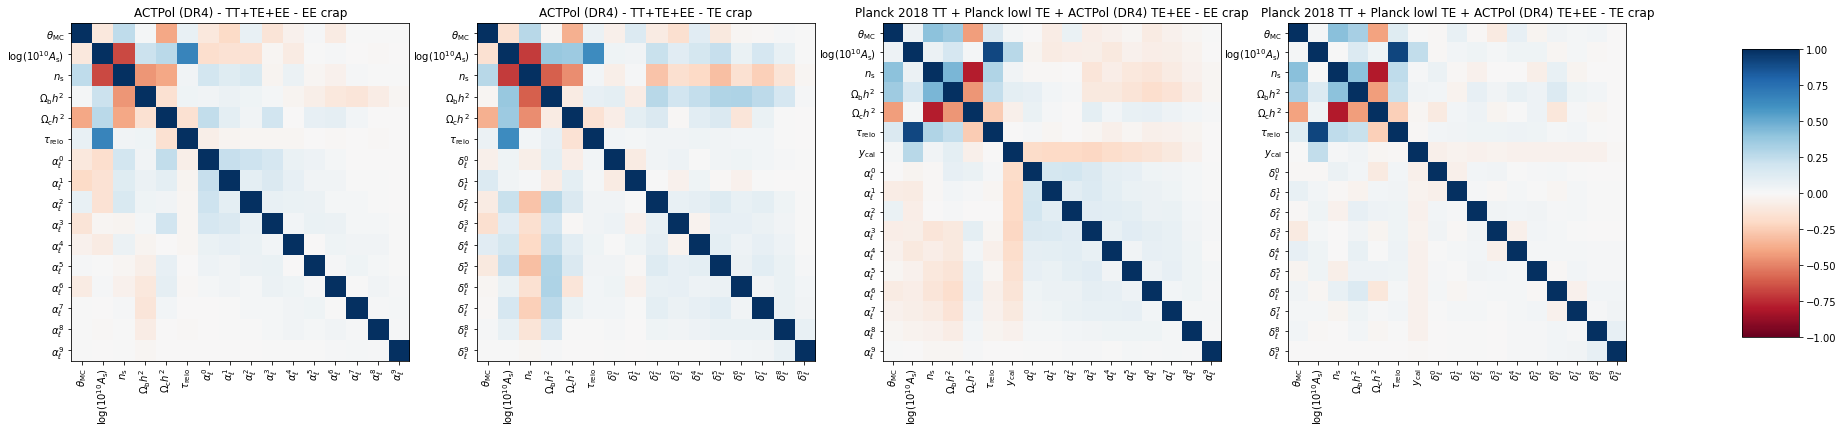

In [23]:
for nuisance, exp in product(["polar", "leakage", "crap"], ["ACTPol"]):
    plot_correlation(get_sample_range(f".*{exp}.*{nuisance}"), sharey=False)

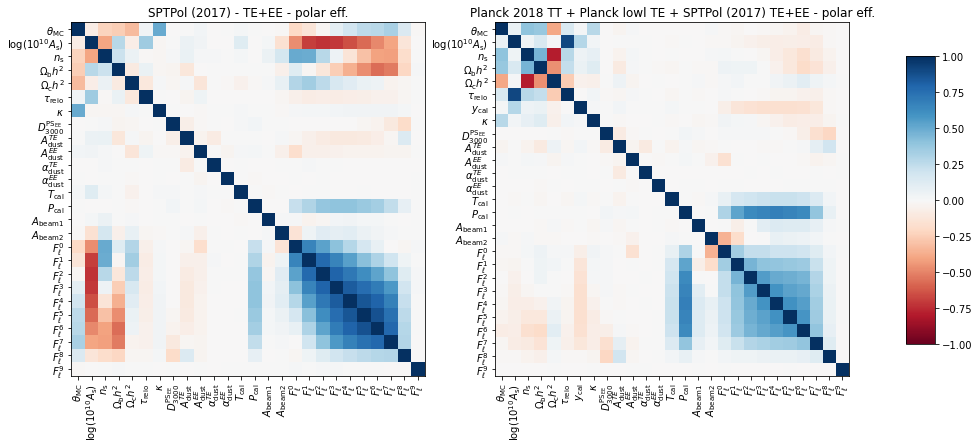

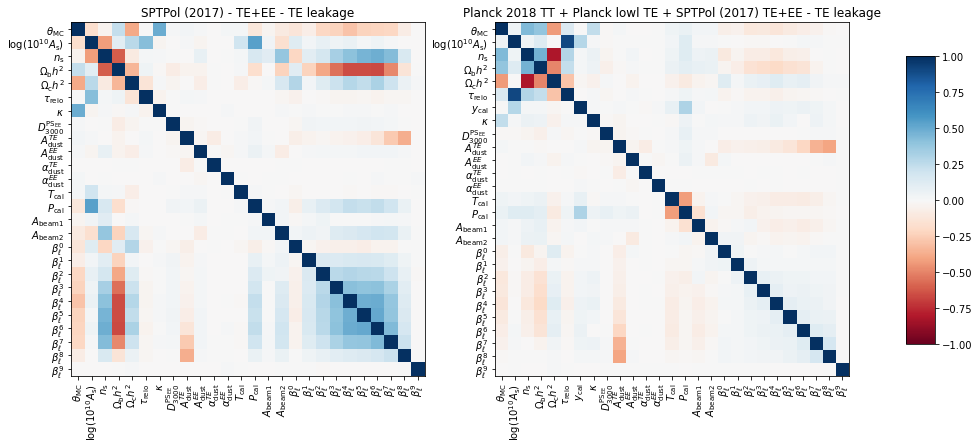

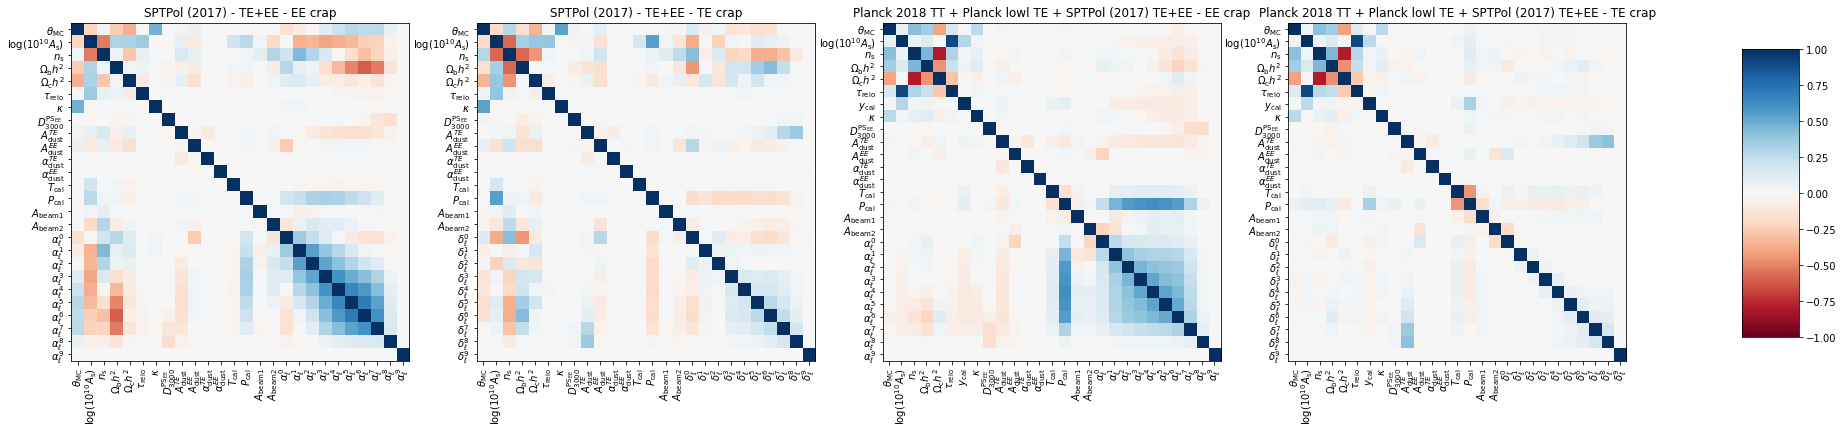

In [24]:
for nuisance, exp in product(["polar", "leakage", "crap"], ["SPTPol"]):
    plot_correlation(get_sample_range(f".*{exp}.*{nuisance}"), sharey=False)

## Results

In [25]:
import ipywidgets as widgets


def show_table(sample_range, params):
    labels = [k for i, k in enumerate(mcmc_samples.keys()) if i in sample_range]
    ssamples = [sample for i, sample in enumerate(samples) if i in sample_range]
    return widgets.HBox(
        [
            widgets.VBox(
                [
                    widgets.HTML(
                        f'<p style="font-weight:bold;width:300px;height:75px"><big>{label}</big></p>'
                    ),
                    widgets.Image(
                        value=sample.getTable(limit=1, paramList=params + ["chi2"])
                        .tablePNG(dpi=150, bytesIO=True)
                        .read(),
                        width=300,
                    ),
                ]
            )
            for sample, label in zip(ssamples, labels)
        ]
    )

In [26]:
show_table(
    get_sample_range("SPTPol.*TE\+EE$") + get_sample_range("Planck.*SPTPol.*"),
    params=cosmo_params + sptpol_params,
)

In [27]:
def plot_results(sample_range, params):
    labels = [k for i, k in enumerate(mcmc_samples.keys()) if i in sample_range]
    ssamples = [sample for i, sample in enumerate(samples) if i in sample_range]
    ccolors = [color for i, color in enumerate(colors) if i in sample_range]

    fig, axes = plt.subplots(1, len(params), sharey=True, figsize=(20, 7))
    plt.subplots_adjust(hspace=0, wspace=0.15)

    for i, ax in enumerate(axes):
        for spine in ["left", "right", "top"]:
            ax.spines[spine].set_color(None)
        ax.set_yticks([])
        if params[i] == "tau":
            ax.axvspan(0.054 - 0.0073, 0.054 + 0.0073, color="0.9")

        for j, (sample, color) in enumerate(zip(ssamples, ccolors)):
            try:
                x = sample.mean(params[i])
                xerr = sample.std(params[i])
            except:
                continue
            if ax.get_xlabel() == "":
                ax.set_xlabel(f"${sample.parLabel(params[i])}$")
            ax.errorbar(x, y=j, xerr=xerr, fmt="o", color=color)

    for i, (label, color) in enumerate(zip(labels, ccolors)):
        axes[0].text(
            0,
            (i + 1) / (len(sample_range) + 1),
            label,
            ha="right",
            va="center",
            color=color,
            transform=axes[0].transAxes,
        )

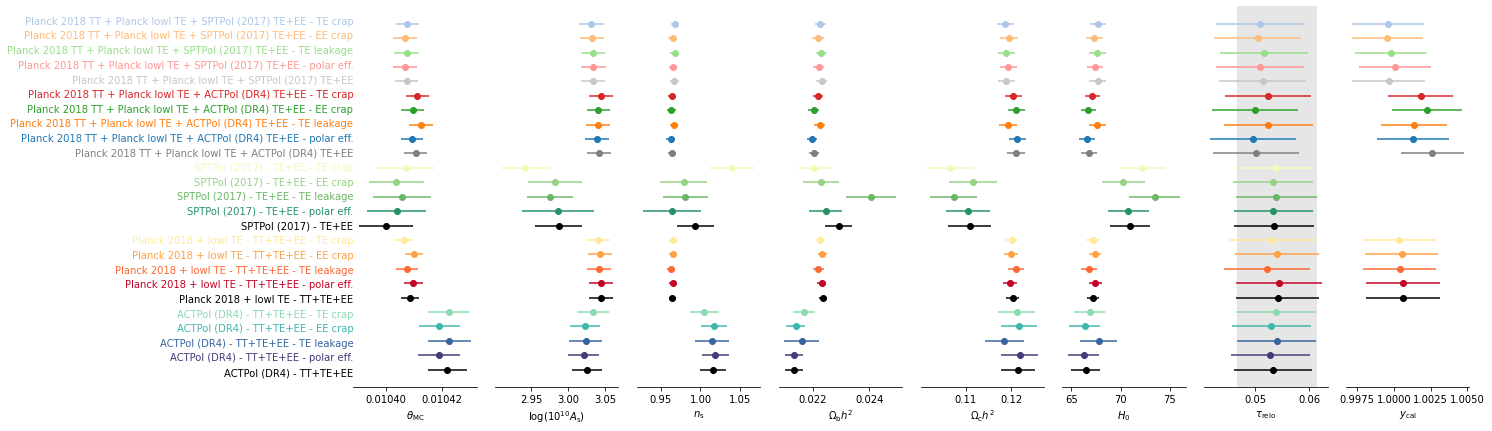

In [28]:
plot_results(get_sample_range(".*"), params=cosmo_params + ["A_planck"])

In [29]:
from scipy import stats

actpol_ell_range = (576, 4325)
sptpol_ell_range = (50, 8000)
planck_ell_range = (30, 1996)


def plot_params(sample_range, ccolors=[f"C{i}" for i in range(5)]):
    labels = [k for i, k in enumerate(mcmc_samples.keys()) if i in sample_range]
    ssamples = [sample for i, sample in enumerate(samples) if i in sample_range]
    if ccolors is None:
        ccolors = [color for i, color in enumerate(colors) if i in sample_range]

    fig = plt.figure(figsize=(10, 8))
    gs = plt.GridSpec(4, 1)
    main = plt.subplot(gs[:3], xticklabels=[])
    dev = plt.subplot(gs[-1])
    for sample, label, color in zip(ssamples, labels, ccolors):
        if "ACTPol" in label:
            ell_range = actpol_ell_range
            n = 10
        elif "SPTPol" in label:
            ell_range = sptpol_ell_range
            n = 10
        elif "Planck" in label:
            ell_range = planck_ell_range
            n = 20
        expected = 1.0
        if "polar eff." in label:
            params = polareff_params(n)
        elif "leakage" in label:
            params = leakage_params(n)
            expected = 0.0
        elif "EE crap" in label:
            params = ee_crap_params(n)
        elif "TE crap" in label:
            params = te_crap_params(n)
        x = np.linspace(*ell_range, len(params) + 1)
        x = x[:-1] + np.diff(x) / 2
        y = sample.mean(params)
        yerr = sample.std(params)
        #chi2 = np.sum((y - expected) ** 2 / yerr ** 2)
        cov = sample.cov(params)
        chi2 = (y - expected) @ np.linalg.inv(cov) @ (y - expected)
        label = f"{label} - $\chi^2$/ndof = {chi2:.2f}/{len(x)} - PTE = {stats.chi2.sf(chi2, len(x)):.2f}"
        main.errorbar(x, y, yerr=yerr, fmt="o", label=label, color=color)
        dev.errorbar(x, (y - expected) / yerr, fmt="o", color=color)
    main.axhline(expected, color="gray", ls="--")
    main.legend(labelcolor=ccolors, loc="upper left", bbox_to_anchor=(1, 1))
    dev.set_xlabel(r"$\ell$")
    dev.set_ylabel(r"$\sigma$")
    dev.axhspan(-1, 1, color="0.9")
    # dev.set_ylim(-3, 3)

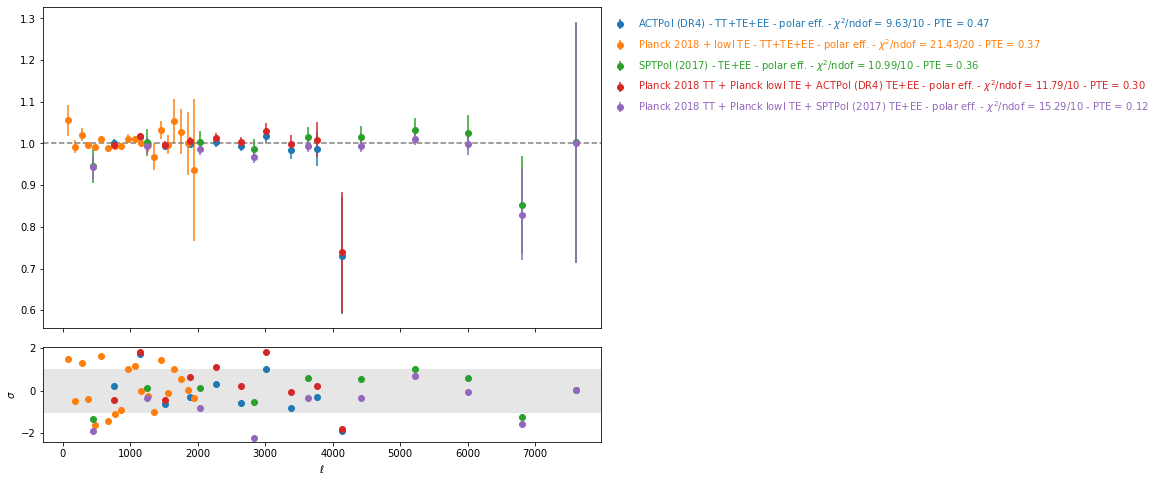

In [30]:
plot_params(get_sample_range(".*polar"))

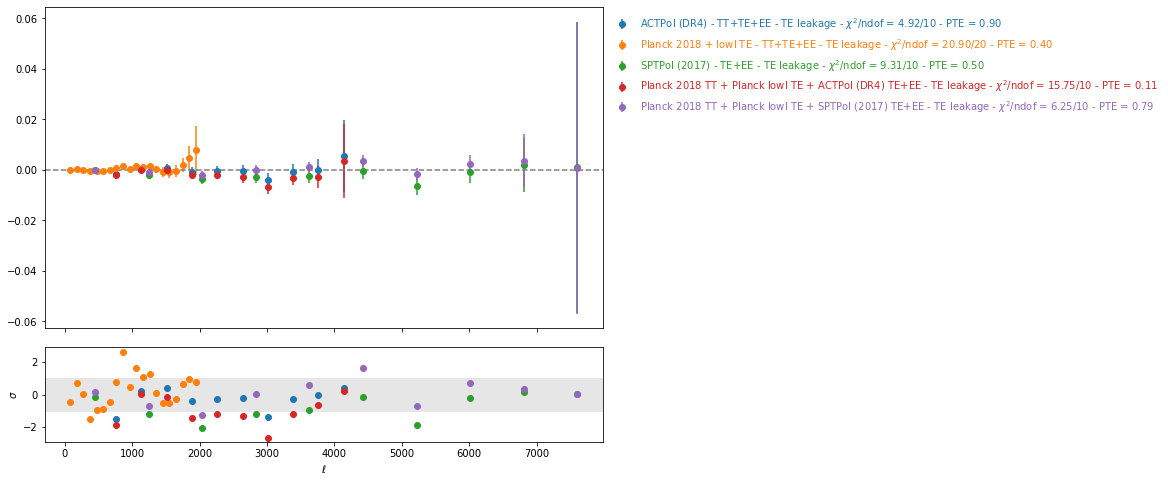

In [31]:
plot_params(get_sample_range(".*leakage"))

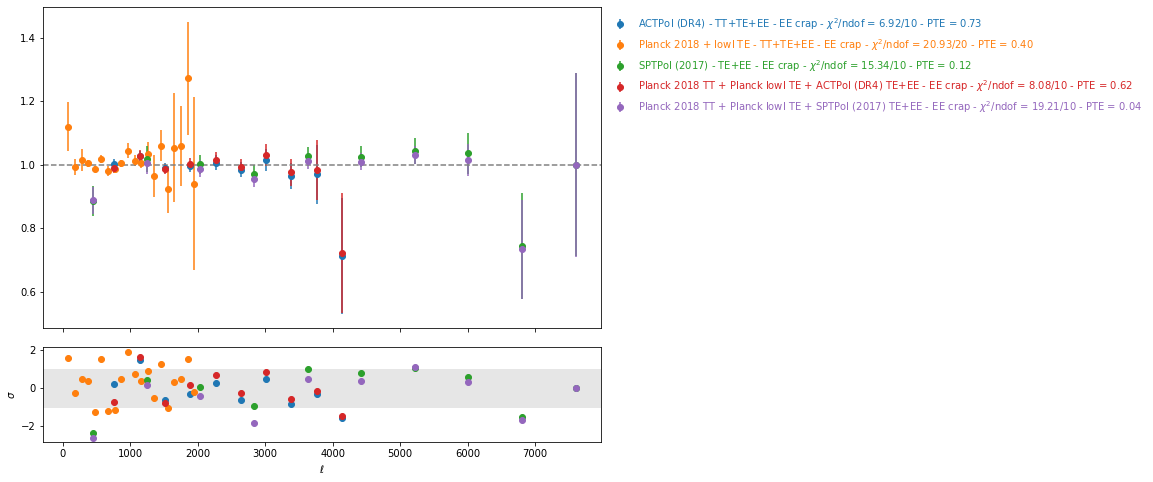

In [32]:
plot_params(get_sample_range(".*EE crap"))

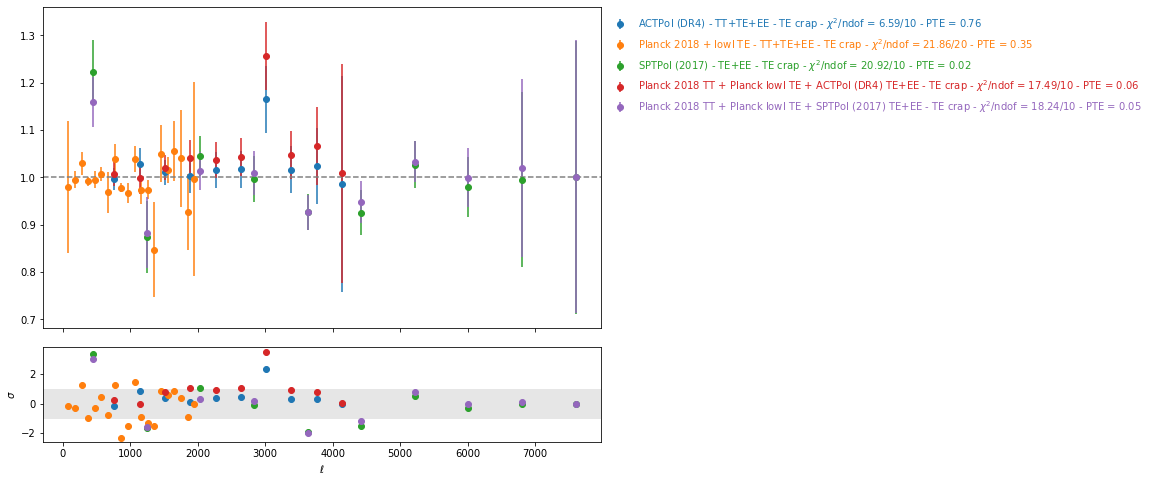

In [33]:
plot_params(get_sample_range(".*TE crap"))